In [1]:
import torch
from torchvision import datasets, transforms
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
BATCH_SIZE = 2048
ENCODING_SIZE = 32
EPOCHS = 400

## Load data

In [3]:
initial_transform = transforms.Compose([transforms.ToTensor(),])
initial_dataset = datasets.MNIST(root='./data', train=True, transform=initial_transform, download=True)
initial_loader = torch.utils.data.DataLoader(initial_dataset, batch_size=len(initial_dataset))

In [4]:
data = next(iter(initial_loader))[0] # gets the entire dataset
current_mean = data.mean().item()
current_std = data.std().item()

In [5]:
print(f"{data.shape = }")
print(f"{current_mean = }")
print(f"{current_std = }")

data.shape = torch.Size([60000, 1, 28, 28])
current_mean = 0.13066047430038452
current_std = 0.30810782313346863


In [6]:
'''
target_mean = 0.5 # for normalizing image data
target_std = 0.5 # for normalizing image data

transform_mean = (current_mean * target_std - target_mean * current_std) / target_std
transform_std = current_std / target_std

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((transform_mean,), (transform_std,)),
])
'''

# The preprint says "Images were normalized to have mean and standard deviation 0.5."
# however, when you actually do that (code commented above) you get weird results. I looked
# in the GitHub for the paper and found the below which does something related but different.
# This transformation results in a model that is easier to train with a mean that is roughly -0.7
# and a std that is roughly 0.6
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)


train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [7]:
# test statistics (see what the current mean and std of the data is)
statistics_test_loader = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
statistics_test_loader = torch.utils.data.DataLoader(statistics_test_loader, batch_size=len(statistics_test_loader))
data = next(iter(statistics_test_loader))[0] # gets the normalized entire dataset
current_mean = data.mean().item()
current_std = data.std().item()
print(f"{data.shape = }")
print(f"{current_mean = }")
print(f"{current_std = }") 

data.shape = torch.Size([60000, 1, 28, 28])
current_mean = -0.7386789917945862
current_std = 0.6162156462669373


## Training

In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        mask_bottom = torch.zeros(32, requires_grad=False)
        mask_bottom[:16] = 1
        self.mask_bottom = mask_bottom
        
        mask_top = torch.zeros(32, requires_grad=False)
        mask_top[16:] = 1
        self.mask_top = mask_top
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 2048),
            nn.ReLU(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, ENCODING_SIZE, bias=False)
        )
        self.decoder = nn.Sequential(
            nn.Linear(ENCODING_SIZE, 512),
            nn.ReLU(),
            nn.Linear(512, 2048),
            nn.ReLU(),
            nn.Linear(in_features=2048, out_features=28*28, bias=True),
        )
        self.top_certificate = nn.Sequential(
            nn.Linear(ENCODING_SIZE//2, 512),
            nn.ReLU(),
            nn.Linear(512, 2048),
            nn.ReLU(),
            nn.Linear(in_features=2048, out_features=28*28, bias=True),
        )
        self.bottom_certificate = nn.Sequential(
            nn.Linear(ENCODING_SIZE//2, 512),
            nn.ReLU(),
            nn.Linear(512, 2048),
            nn.ReLU(),
            nn.Linear(in_features=2048, out_features=28*28, bias=True),
        )

    def forward(self, x, y):
        encoding = self.encoder(x)
        encoding.retain_grad()
        detached_encoding = encoding.detach()
        
        all_masks = torch.zeros(encoding.shape)
        top_masks = y > 4
        bottom_masks = y <= 4
        

        all_masks = torch.zeros(encoding.shape)
        all_masks[top_masks] = self.mask_top
        all_masks[bottom_masks] = self.mask_bottom
        all_masks = all_masks.to(device)

        masked_encoding = all_masks * encoding + (1 - all_masks) * detached_encoding   
        
        encoding_top = (detached_encoding[:,ENCODING_SIZE//2:])
        encoding_bottom = (detached_encoding[:,:ENCODING_SIZE//2])
        
        top_cert = self.top_certificate(encoding_top)
        bottom_cert = self.bottom_certificate(encoding_bottom)
        
        logits = self.decoder(masked_encoding)
        
        return encoding, logits, top_cert, bottom_cert

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=32, bias=False)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=784, bias=True)
  )
  (top_certificate): Sequential(
    (0): Linear(in_features=16, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=784, bias=True)
  )
  (bottom_certificate): Sequential(
    (0): Linear(in_features=16, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_fe

In [11]:
l1_loss = nn.L1Loss()
def loss_fn(X, X_hat, X_hat_top_cert, X_hat_bottom_cert, encoding, lambda_term=0.001, gamma=0.01):
    # Mean absolute error for reconstruction
    mae_top_cert = l1_loss(X, X_hat_top_cert)
    mae_bottom_cert = l1_loss(X, X_hat_bottom_cert)
    decoder_mae = l1_loss(X, X_hat)
    mae_reconstruction = decoder_mae + mae_top_cert + mae_bottom_cert
    
    # L1 norm for encoding
    encoding_loss = torch.norm(encoding, p=1) * lambda_term * (1/BATCH_SIZE)
    
    total_loss = mae_reconstruction + encoding_loss # + correlation_scores
    
    return decoder_mae, encoding_loss, mae_top_cert, mae_bottom_cert, total_loss

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-5)

In [21]:
def train(data_loader, loss, optimizer, model, epochs=1):
    model.train()
    train_loss_statistics = []
    decoder_maes = []
    encoding_losses = []
    mae_top_certs_loss = []
    mae_bottom_certs_loss = []
    
    for epoch in range(epochs):
        for batch_idx, data in enumerate(data_loader):
            X, y = data
            X = torch.flatten(X, start_dim=1).to(device)
            encoding, X_hat, X_hat_top_cert, X_hat_bottom_cert = model.forward(X, y)
       

            decoder_mae, encoding_loss, mae_top_cert, mae_bottom_cert, batch_loss = loss(X, X_hat, X_hat_top_cert, X_hat_bottom_cert, encoding)
            
            batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss_statistics.append(batch_loss.item())
            decoder_maes.append(decoder_mae.item())
            encoding_losses.append(encoding_loss.item())
            mae_top_certs_loss.append(mae_top_cert.item())
            mae_bottom_certs_loss.append(mae_bottom_cert.item())
            
            current_batch = len(data_loader)*epoch + batch_idx
            if current_batch % 300 == 0:
                print(f"({epoch}): #{len(data_loader)*epoch + batch_idx}:\t {batch_loss:.4}")
                print(f"decoder:\t {decoder_mae:.4}")
                print(f"Top cert loss:\t {mae_top_cert:.4}")
                print(F"L1 loss:\t {encoding_loss:.4}")
                
                # check to see if gradient routing is working
                first_half_encoding_grad = torch.abs(encoding.grad[0][:16])
                print(y[0].item(), torch.sum(first_half_encoding_grad - first_half_encoding_grad[0]))
                print("-------------------\n")
                
    return decoder_maes, encoding_losses, mae_top_certs_loss, mae_bottom_certs_loss, train_loss_statistics

In [22]:
train_rv = train(train_loader, loss_fn, optimizer, model, epochs=EPOCHS)

(0): #0:	 1.286
decoder:	 0.4285
Top cert loss:	 0.4089
L1 loss:	 0.05242
1 tensor(-8.1516e-05, device='mps:0')
-------------------

(10): #300:	 0.6718
decoder:	 0.2158
Top cert loss:	 0.2336
L1 loss:	 0.001544
0 tensor(-1.9062e-05, device='mps:0')
-------------------

(20): #600:	 0.5918
decoder:	 0.177
Top cert loss:	 0.2146
L1 loss:	 0.002911
9 tensor(0., device='mps:0')
-------------------

(30): #900:	 0.5401
decoder:	 0.153
Top cert loss:	 0.198
L1 loss:	 0.003777
1 tensor(-5.4758e-05, device='mps:0')
-------------------

(40): #1200:	 0.5144
decoder:	 0.14
Top cert loss:	 0.1901
L1 loss:	 0.004225
1 tensor(1.8025e-05, device='mps:0')
-------------------

(50): #1500:	 0.5078
decoder:	 0.1331
Top cert loss:	 0.1895
L1 loss:	 0.004543
8 tensor(0., device='mps:0')
-------------------

(60): #1800:	 0.4865
decoder:	 0.1224
Top cert loss:	 0.1849
L1 loss:	 0.004917
7 tensor(0., device='mps:0')
-------------------

(70): #2100:	 0.4836
decoder:	 0.1227
Top cert loss:	 0.1815
L1 loss:

In [23]:
decoder_maes, encoding_losses, mae_top_certs_loss, mae_bottom_certs_loss, train_loss_statistics = train_rv

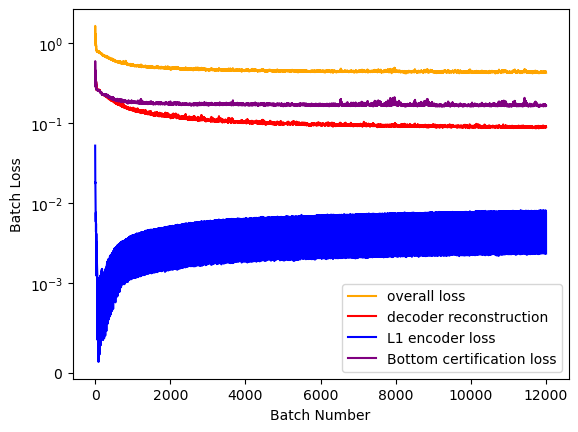

In [24]:
plt.plot(np.arange(0, len(train_loss_statistics)), train_loss_statistics, color='orange', label="overall loss")
plt.plot(np.arange(0, len(train_loss_statistics)), decoder_maes, color='red', label="decoder reconstruction")
plt.plot(np.arange(0, len(train_loss_statistics)), encoding_losses, color='blue', label="L1 encoder loss")
plt.plot(np.arange(0, len(train_loss_statistics)), mae_bottom_certs_loss, color='purple', label="Bottom certification loss")

plt.xlabel("Batch Number")
plt.ylabel("Batch Loss")
plt.yscale('symlog', linthresh=1e-3)
plt.legend()
plt.savefig(f"{EPOCHS}_epochs_with_certs/loss.png")
plt.show()

## Testing Certificates

In [25]:
test_images_batch, test_labels_batch = next(iter(test_loader))

In [26]:
encoding, X_hat, X_hat_top_cert, X_hat_bottom_cert = model.forward(
    torch.flatten(test_images_batch, start_dim=1).to(device),
    test_labels_batch.to(device)
)

In [27]:
low_digits = torch.flatten(test_images_batch[test_labels_batch <= 4,...], start_dim=1)
high_digits = torch.flatten(test_images_batch[test_labels_batch > 4,...], start_dim=1)
bottom_cert_low_digits = X_hat_top_cert[test_labels_batch <= 4,:].to('cpu')
bottom_cert_high_digits = X_hat_top_cert[test_labels_batch > 4,:].to('cpu')
low_digits_loss = l1_loss(low_digits, bottom_cert_low_digits)
high_digits_loss = l1_loss(high_digits, bottom_cert_high_digits)

In [28]:
low_digits_loss, high_digits_loss

(tensor(0.2201, grad_fn=<MeanBackward0>),
 tensor(0.1181, grad_fn=<MeanBackward0>))

## Generating Image Samples

In [29]:
# get reconstructed images
top_cert_imgs_high = X_hat_top_cert[test_labels_batch > 4].detach().to('cpu').view(-1, 28, 28)
top_cert_imgs_low = X_hat_top_cert[test_labels_batch <= 4].detach().to('cpu').view(-1, 28, 28)

bottom_cert_imgs_high = X_hat_bottom_cert[test_labels_batch > 4].detach().to('cpu').view(-1, 28, 28)
bottom_cert_imgs_low = X_hat_bottom_cert[test_labels_batch <= 4].detach().to('cpu').view(-1, 28, 28)

test_images_batch_high = test_images_batch[test_labels_batch > 4]
test_images_batch_low = test_images_batch[test_labels_batch <= 4]

In [30]:
def print_reconstructions(imgs, reconstructed_imgs, title, img_path):
    columns = 12
    rows = 2
    fig, axes = plt.subplots(rows, columns, figsize=(18, 5))
    for i, ax in enumerate(axes.flat):
        if i >= columns:
            ax.imshow(reconstructed_imgs[i - columns]* -1, cmap='gray')
        else:
            ax.imshow(imgs[i].squeeze()* -1, cmap='gray')
        ax.axis('off')
    fig.suptitle(title, fontsize=16)
    plt.savefig(img_path, dpi=300)
    plt.show()

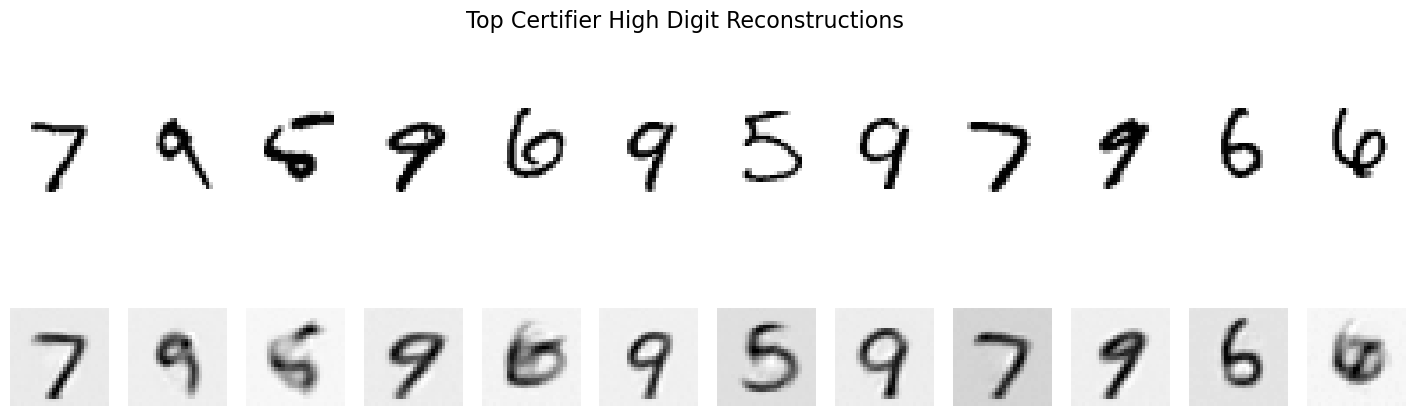

In [31]:
print_reconstructions(
    test_images_batch_high,
    top_cert_imgs_high,
    "Top Certifier High Digit Reconstructions",
    f"{EPOCHS}_epochs_with_certs/top_cert_high_digits.png"
)

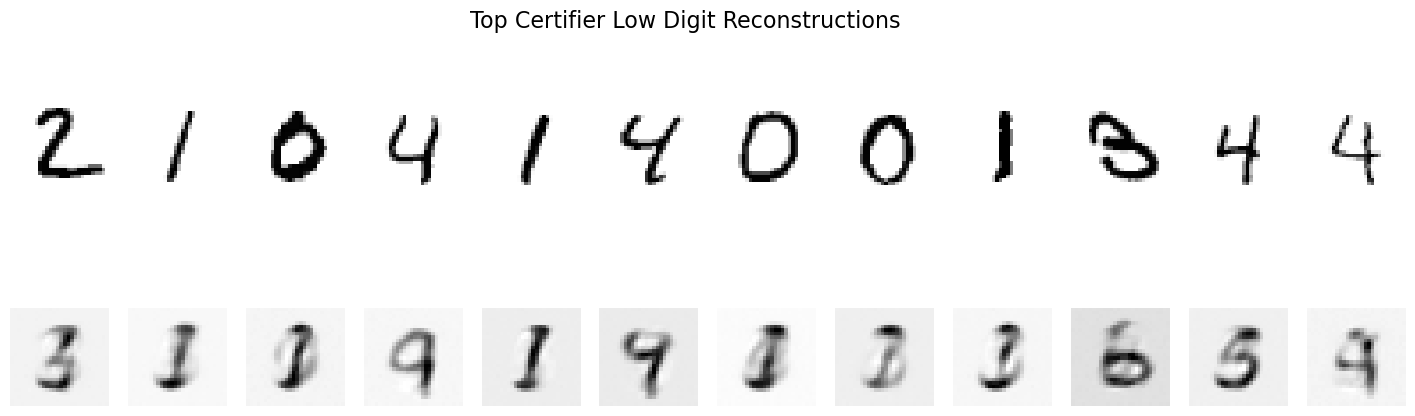

In [32]:
print_reconstructions(
    test_images_batch_low,
    top_cert_imgs_low,
    "Top Certifier Low Digit Reconstructions",
    f"{EPOCHS}_epochs_with_certs/top_cert_low_digits.png"
)

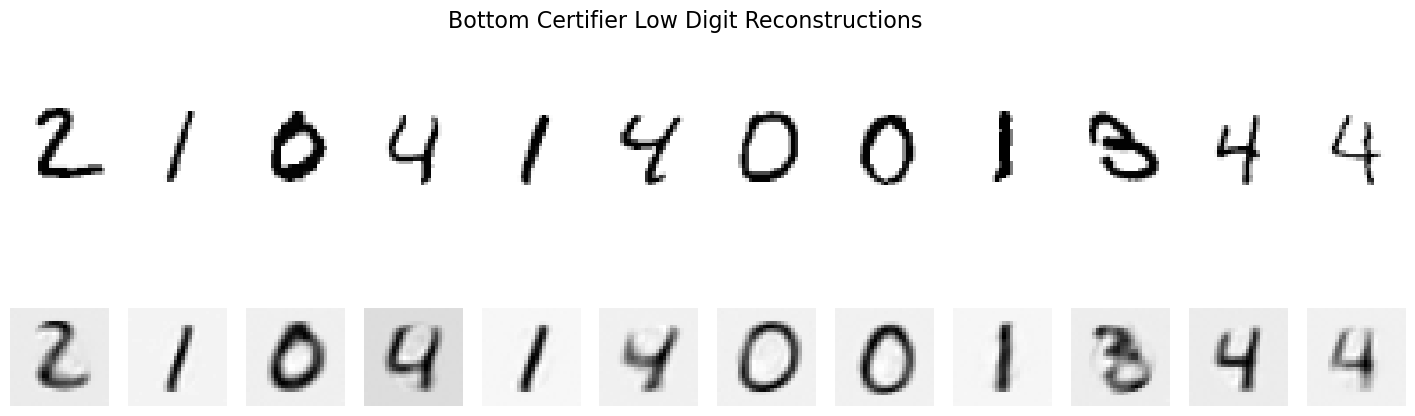

In [33]:
print_reconstructions(
    test_images_batch_low,
    bottom_cert_imgs_low,
    "Bottom Certifier Low Digit Reconstructions",
    f"{EPOCHS}_epochs_with_certs/bottom_cert_low_digits.png"
)

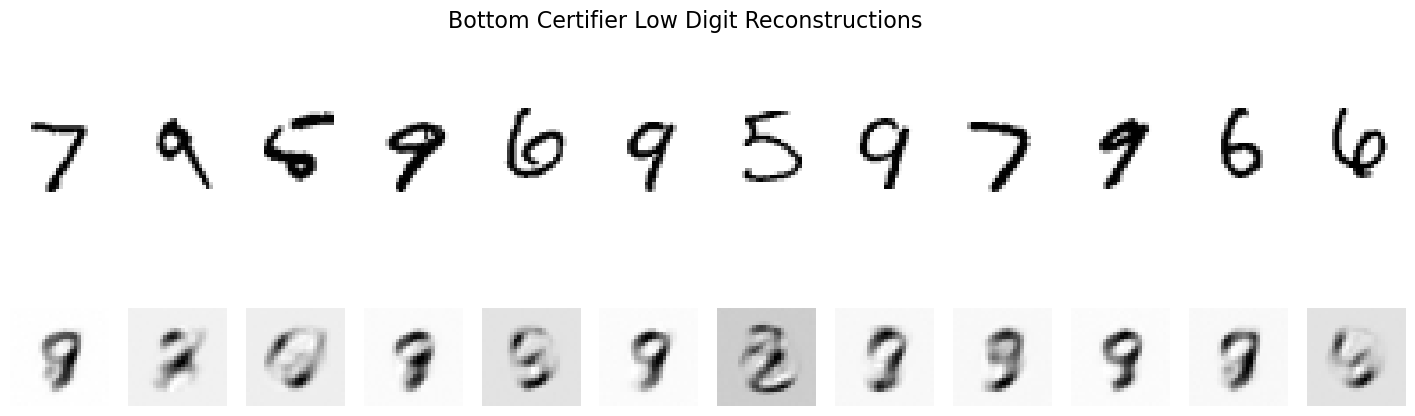

In [34]:
print_reconstructions(
    test_images_batch_high,
    bottom_cert_imgs_high,
    "Bottom Certifier Low Digit Reconstructions",
    f"{EPOCHS}_epochs_with_certs/bottom_cert_high_digits.png"
)

In [35]:
test_data = next(iter(test_loader))

In [45]:
top_cert_losses = dict()
bottom_cert_losses = dict()

X, y = next(iter(test_loader))
X = torch.flatten(X, start_dim=1).to(device)

for i in range(10):

    X_current = X[y == i]
    y_current = y[y == i]

    encoding, X_hat, X_hat_top_cert, X_hat_bottom_cert = model.forward(X_current, y_current)

    top_cert_losses[i] = l1_loss(X_current, X_hat_top_cert).detach().item()
    bottom_cert_losses[i] = l1_loss(X_current, X_hat_bottom_cert).detach().item()

In [46]:
top_cert_losses

{0: 0.31021848320961,
 1: 0.13343237340450287,
 2: 0.2568370997905731,
 3: 0.21679817140102386,
 4: 0.19507987797260284,
 5: 0.13217712938785553,
 6: 0.12193742394447327,
 7: 0.10032127052545547,
 8: 0.141704723238945,
 9: 0.09738824516534805}

In [47]:
bottom_cert_losses

{0: 0.12685389816761017,
 1: 0.05508304014801979,
 2: 0.14249765872955322,
 3: 0.1392146497964859,
 4: 0.13476888835430145,
 5: 0.22765247523784637,
 6: 0.2502793073654175,
 7: 0.18825660645961761,
 8: 0.23488183319568634,
 9: 0.18453924357891083}

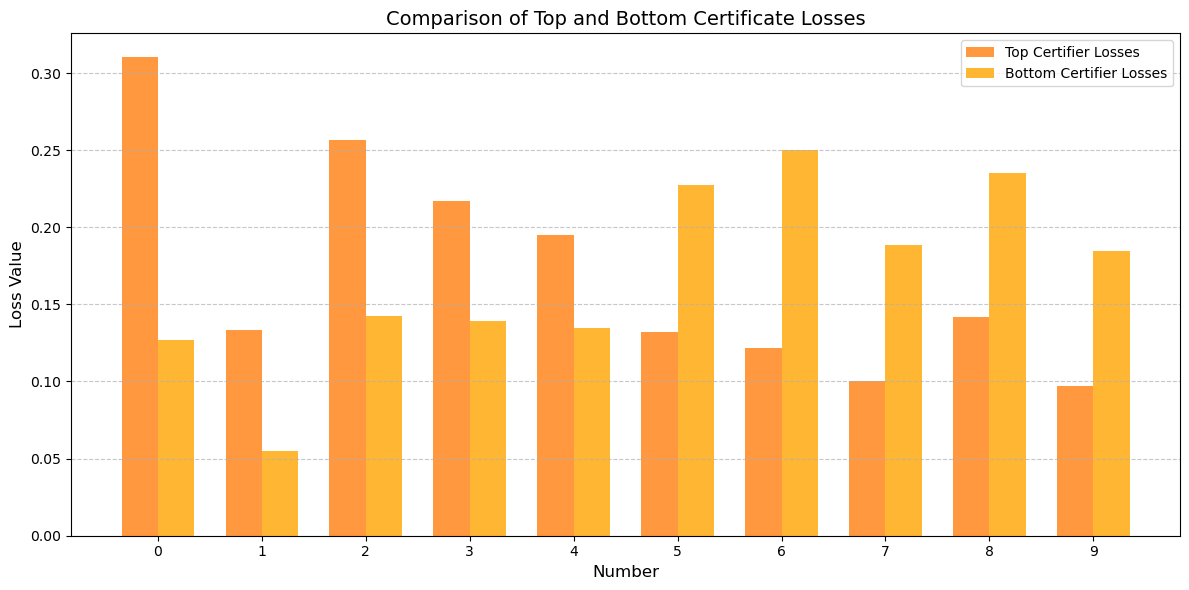

In [50]:
plt.figure(figsize=(12, 6))

x = np.arange(len(top_cert_losses))
width = 0.35

plt.bar(x - width/2, top_cert_losses.values(), width, label='Top Certifier Losses', color='#ff7f0e', alpha=0.8)
plt.bar(x + width/2, bottom_cert_losses.values(), width, label='Bottom Certifier Losses',color='#ffa500', alpha=0.8)

plt.xlabel('Number', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.title('Comparison of Top and Bottom Certificate Losses', fontsize=14)
plt.xticks(x, range(10))
plt.legend()


plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f"{EPOCHS}_epochs_with_certs/compare_certifiers.png", dpi=300)
plt.show()

## Saving Model

In [49]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': EPOCHS,
}, f"{EPOCHS}_epochs_with_certs/model.pth")